<h1 style="text-align: center;"><a href="https://www.whatwouldaithink.com">WhatWouldAiThink.com</a></h1>


<h3 style="text-align: center;">Classification of Cats and Dogs</h3>

<h3 style="text-align: center;">April 2024</h3>

<h3 style="text-align: center;">This notebook is made for the analysis of cats and dogs published on:
<a href="https://www.whatwouldaithink.com">whatwouldaithink.com</a></h3>
<h4 style="text-align: center;">Copyright © 2022-Present whatwouldaithink.com - All Rights Reserved</h4>

<h1 style="text-align: center;"> Train a CNN model with color and augmented color images </h1>

In [1]:
# import basics
import os
from pathlib import Path
import time

# import torch
import torch
from random import randrange
torch.manual_seed(0)

# custom modules
import sys
sys.path.append('..')
from vision.Utils import info
from vision.Definitions import *
from vision.Utils import printNumOfLearnableWeights, printModelSize
from vision.Utils import readDataToDataFrame, createDirectories
from vision.TransformImages import TransformImages
from vision.Data import Data
from vision.Models import CNN
from vision.ValidationTools import MyValidator, ValidatePretrainedModel
from vision.TrainModels import TrainingManager
# MIN_SIZE_IMAGE is 224, defined in vision.Definitions

pathDataSet = "datasets"
pathDataSet224x224 = f"datasets{MIN_SIZE_IMAGE[0]}x{MIN_SIZE_IMAGE[1]}"
pathDataSetAugmented224x224 = f"datasets_augmented{MIN_SIZE_IMAGE[0]}x{MIN_SIZE_IMAGE[1]}"

<h1>1. Check and preprocess the data</h1>

### Create the DataFrames

In [2]:
# "training_set" and "test_set" are from https://www.kaggle.com/datasets/charmz/cats-and-dogs
df_train = readDataToDataFrame(os.path.join(pathDataSet, "training_set"))
df_test = readDataToDataFrame(os.path.join(pathDataSet, "test_set"))

# "validate_set" and "validate_set_cropped" are from https://github.com/WhatWouldAiThink/About_Cats_in_Montenegro
df_validate = readDataToDataFrame(os.path.join(pathDataSet, "validate_set"))
df_validateCropped = readDataToDataFrame(os.path.join(pathDataSet, "validate_set_cropped"))

Reading files from folder: datasets/training_set/cats
Reading files from folder: datasets/training_set/dogs
Reading files from folder: datasets/test_set/cats
Reading files from folder: datasets/test_set/dogs
Reading files from folder: datasets/validate_set/cats
Reading files from folder: datasets/validate_set_cropped/cats


### Create the DataSets

In [3]:
dataSetTrain = Data(df_train)
dataSetTest = Data(df_test)
dataSetValidate = Data(df_validate)
dataSetValidateCropped = Data(df_validateCropped)

### Plot images for all DataSets to get an idea of the data.

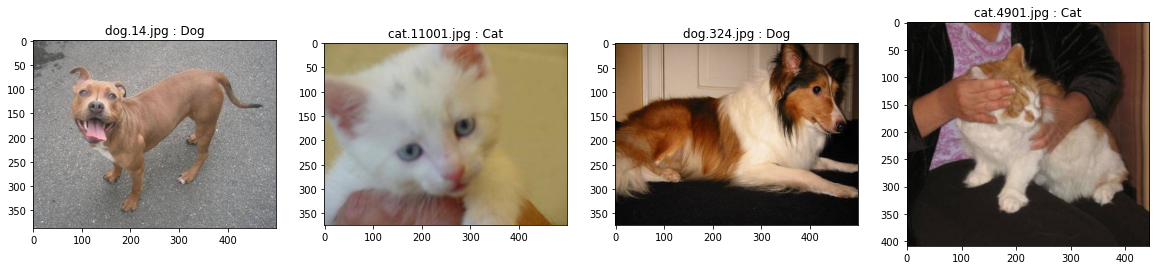

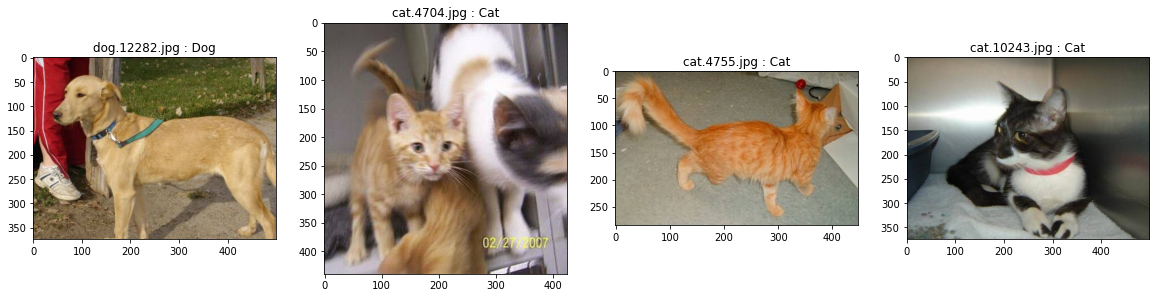

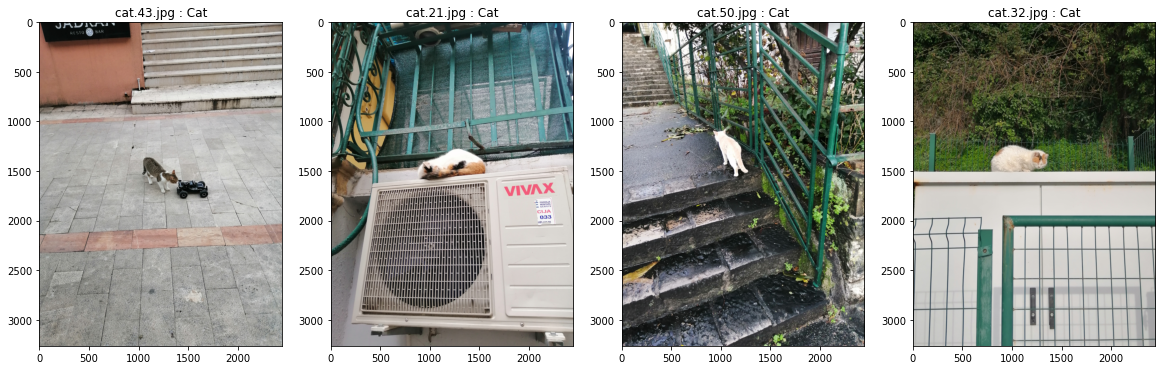

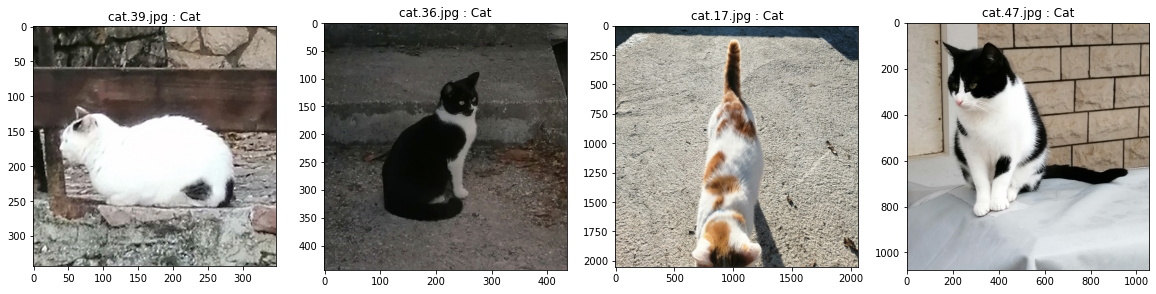

In [4]:
for dataSet in [dataSetTrain, dataSetTest, dataSetValidate, dataSetValidateCropped]:
    rows = dataSet.__len__()
    dataSet.plotImages([randrange(0, rows) for _ in range(4)])

### Check the data frame and basic statistics from the data. There are some really small images with a height of 32 pixel in the training set and a height of 37 pixel in the test set.

In [5]:
df_train.describe()

label         width        height
count  20000.000000  20000.000000  20000.000000
mean       0.500000    404.346300    361.012650
std        0.500013    108.918243     96.934388
min        0.000000     42.000000     32.000000
25%        0.000000    323.000000    302.000000
50%        0.500000    448.000000    374.000000
75%        1.000000    499.000000    421.000000
max        1.000000   1050.000000    768.000000

In [6]:
df_test.describe()

label        width       height
count  5000.00000  5000.000000  5000.000000
mean      0.50000   403.110000   358.339800
std       0.50005   109.520716    97.341856
min       0.00000    51.000000    37.000000
25%       0.00000   320.000000   300.000000
50%       0.50000   447.000000   374.000000
75%       1.00000   499.000000   417.000000
max       1.00000   500.000000   500.000000

In [7]:
df_validate.describe()

label        width       height
count   61.0    61.000000    61.000000
mean     1.0  2527.475410  3338.754098
std      0.0   223.236168   292.742017
min      1.0  2448.000000  2448.000000
25%      1.0  2448.000000  3264.000000
50%      1.0  2448.000000  3264.000000
75%      1.0  2448.000000  3264.000000
max      1.0  3264.000000  4160.000000

In [8]:
df_validateCropped.describe()

label        width       height
count   61.0    61.000000    61.000000
mean     1.0   911.934426   912.409836
std      0.0   421.703050   417.724526
min      1.0   324.000000   336.000000
25%      1.0   668.000000   656.000000
50%      1.0   818.000000   812.000000
75%      1.0  1100.000000  1112.000000
max      1.0  2168.000000  2168.000000

### Plot the size of the images

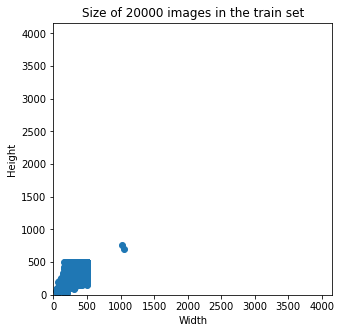

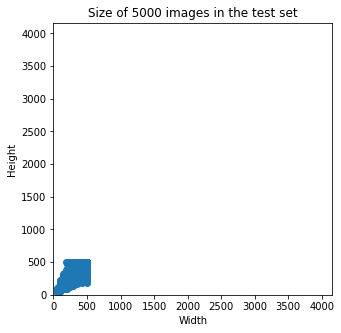

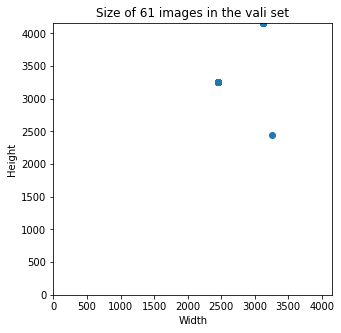

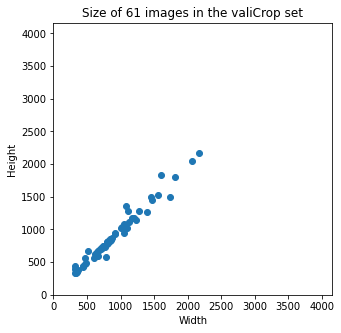

In [9]:
# plot the height and width of the train and test images
import matplotlib.pyplot as plt
import numpy as np

max_Pixel = np.array([df_train["width"].max(), df_test["width"].max(), df_validate["width"].max(),df_validateCropped["width"].max(),
              df_train["height"].max(), df_test["height"].max(), df_validate["height"].max(), df_validateCropped["height"].max()])

min_max_Pixel = (0, np.max(max_Pixel)) 

for df, name in zip([df_train, df_test, df_validate, df_validateCropped], ["train", "test", "vali", "valiCrop"]):
    fig = plt.figure(figsize=figSize)
    ax = plt.axes()
    ax.plot(df["width"], df["height"], "o")
    ax.set_xlabel("Width")
    ax.set_ylabel("Height")
    ax.set_xlim(min_max_Pixel[0], min_max_Pixel[1])
    ax.set_ylim(min_max_Pixel[0], min_max_Pixel[1])
    plt.title(f"Size of {df.shape[0]} images in the {name} set")

### Plot the images with the smallest size

The image with the smallest width from the training set has a width of 42 pixel.


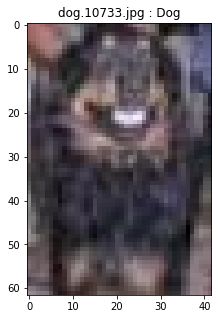

The image with the smallest height from the training set has a height of 32 pixel.


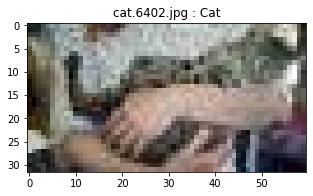

The image with the smallest width from the test set has a width of 51 pixel.


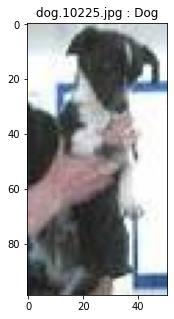

The image with the smallest height from the test set has a height of 37 pixel.


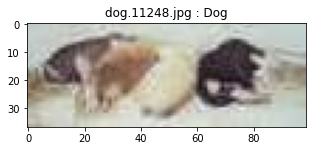

In [10]:
# plot the images with the smallest width and height from the training and test set
for (nameDataSet, data_set, data_frame) in zip(
    ["training", "test"], [dataSetTrain, dataSetTest], [df_train, df_test]):
    for feature in ["width", "height"]:        
        print(f"""The image with the smallest {feature} from the {nameDataSet} set \
has a {feature} of {data_frame[feature].min()} pixel.""")
        data_set.plotImages([data_frame[feature].idxmin()])

<h1>2. Filter the data for training a CNN </h1>

### Create a new directory and resize the images to MIN_SIZE_IMAGE

In [11]:
# create a new directory with subfolders for images with size MIN_SIZE_IMAGE
folders = ["training_set", 
           "test_set", 
           "validate_set", 
           "validate_set_cropped"]
    
# resize the images and save it in the new directory             
if createDirectories(pathDataSet224x224, folders):
    transformer = TransformImages(pathDataSet, pathDataSet224x224, resize=True, size=MIN_SIZE_IMAGE)
    transformer.resize() 

directory: datasets224x224/training_set/cats already exists
Stop creating any directory


### Create new DataFrames with equal image size MIN_SIZE_IMAGE

In [12]:
df_train    = readDataToDataFrame(os.path.join(pathDataSet224x224, "training_set"))
df_test     = readDataToDataFrame(os.path.join(pathDataSet224x224, "test_set"))
df_validate = readDataToDataFrame(os.path.join(pathDataSet224x224, "validate_set"))
df_validateCropped = readDataToDataFrame(os.path.join(pathDataSet224x224, "validate_set_cropped"))

Reading files from folder: datasets224x224/training_set/cats
Reading files from folder: datasets224x224/training_set/dogs
Reading files from folder: datasets224x224/test_set/cats
Reading files from folder: datasets224x224/test_set/dogs
Reading files from folder: datasets224x224/validate_set/cats
Reading files from folder: datasets224x224/validate_set_cropped/cats


### Check the new DataFrames and basic statistics. We see that all small images have equal size of 224x224 pixel.

In [13]:
df_train.describe()

label    width   height
count  17650.000000  17650.0  17650.0
mean       0.499150    224.0    224.0
std        0.500013      0.0      0.0
min        0.000000    224.0    224.0
25%        0.000000    224.0    224.0
50%        0.000000    224.0    224.0
75%        1.000000    224.0    224.0
max        1.000000    224.0    224.0

In [14]:
df_test.describe()

label   width  height
count  4395.000000  4395.0  4395.0
mean      0.500114   224.0   224.0
std       0.500057     0.0     0.0
min       0.000000   224.0   224.0
25%       0.000000   224.0   224.0
50%       1.000000   224.0   224.0
75%       1.000000   224.0   224.0
max       1.000000   224.0   224.0

In [15]:
df_validate.describe()

label  width  height
count   61.0   61.0    61.0
mean     1.0  224.0   224.0
std      0.0    0.0     0.0
min      1.0  224.0   224.0
25%      1.0  224.0   224.0
50%      1.0  224.0   224.0
75%      1.0  224.0   224.0
max      1.0  224.0   224.0

In [16]:
df_validateCropped.describe()

label  width  height
count   61.0   61.0    61.0
mean     1.0  224.0   224.0
std      0.0    0.0     0.0
min      1.0  224.0   224.0
25%      1.0  224.0   224.0
50%      1.0  224.0   224.0
75%      1.0  224.0   224.0
max      1.0  224.0   224.0

### Create new DataSets with equal image size MIN_SIZE_IMAGE

In [17]:
dataSetTrain = Data(df_train)
dataSetTest = Data(df_test)
dataSetValidate = Data(df_validate)
dataSetValidateCropped = Data(df_validateCropped)

### Print some random pictures to check if the MIN_SIZE_IMAGE is good.

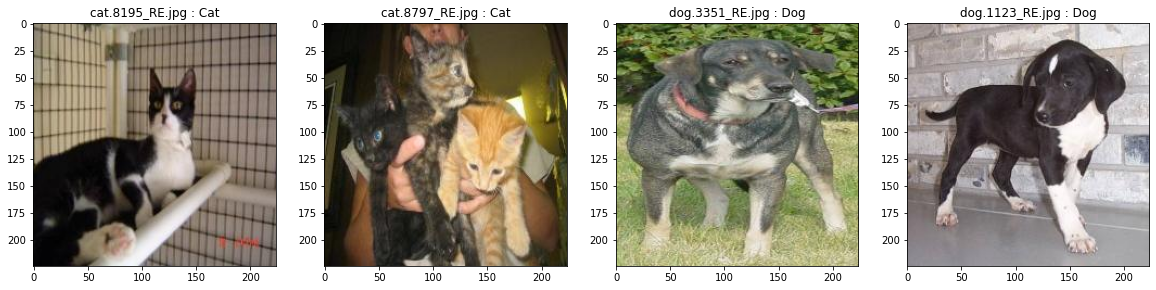

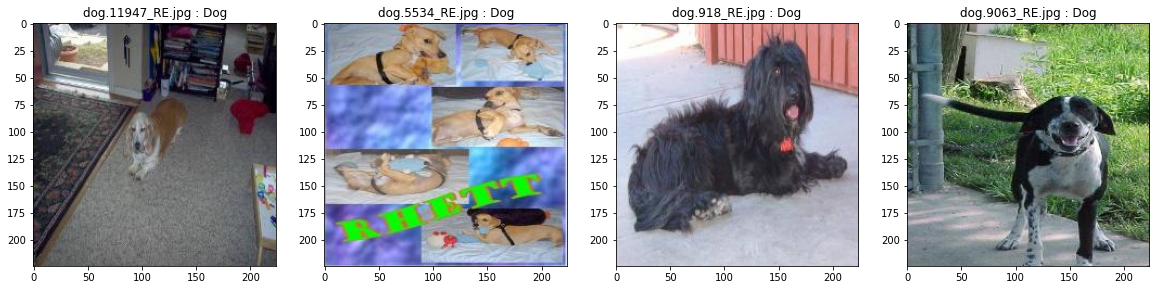

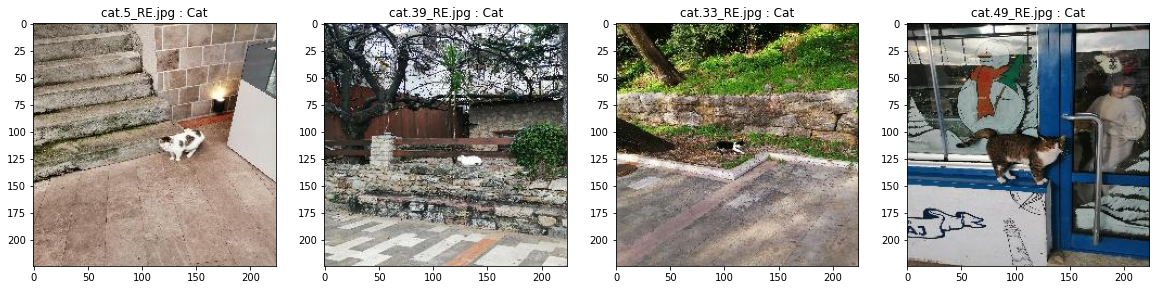

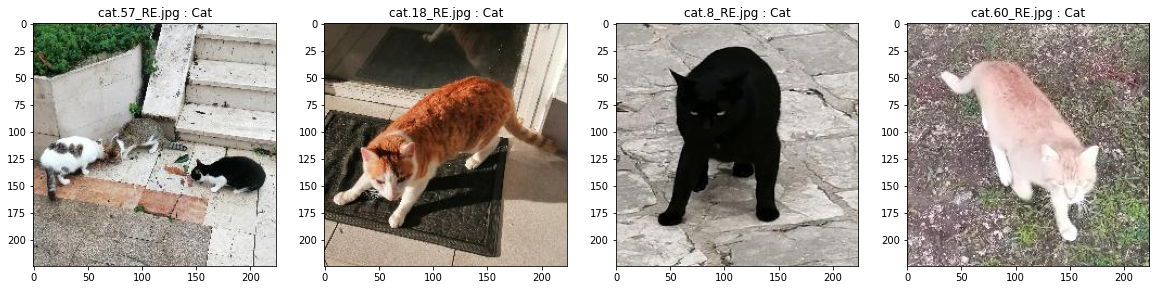

In [18]:
for dataSet in [dataSetTrain, dataSetTest, dataSetValidate, dataSetValidateCropped]:
    rows = dataSet.__len__()
    dataSet.plotImages([randrange(0, rows) for _ in range(4)])

### Count the number of cats and dogs in the train and test set. Both set's are almost balanced.

In [19]:
for (df, nameDataFrame) in zip([df_train, df_test], ["train", "test"]):
    for label in [0, 1]:
        print(f"There are {df[df['label'] == label].shape[0]} {labelDic[label]}s in the {nameDataFrame} set.")


There are 8840 Dogs in the train set.
There are 8810 Cats in the train set.
There are 2197 Dogs in the test set.
There are 2198 Cats in the test set.


<h1>3. Train a CNN with color images</h1>

In [20]:
# define the params for the convolution layers
conv1 = {"inChannels" : 3, "outChannels" : 32,
         "cKernel" : 5, "cStride" : 1, "cPadding" : 2}
conv2 = {"inChannels" : 32, "outChannels" : 64,
         "cKernel" : 5, "cStride" : 1, "cPadding" : 2}
conv3 = {"inChannels" : 64, "outChannels" : 128,
         "cKernel" : 5, "cStride" : 1, "cPadding" : 2}
conv4 = {"inChannels" : 128, "outChannels" : 256,
         "cKernel" : 5, "cStride" : 1, "cPadding" : 2}
conv5 = {"inChannels" : 256, "outChannels" : 512,
         "cKernel" : 5, "cStride" : 1, "cPadding" : 2}
    
# create the model    
model = CNN(imageSize=MIN_SIZE_IMAGE,
              convLayers=[conv1, conv2, conv3, conv4, conv5], 
              fullConLayers=[1],              
              dropOut=0.5)

printNumOfLearnableWeights(model)
printModelSize(model)
display(model)

Creating a CNN with the following architecture:

Convolution Layer: 0
Channels in: 3
Channels out: 32
Reading default parameters for max pooling
Size Image out Conv: (224, 224)
Size Image out MaxPool: (112, 112)

Convolution Layer: 1
Channels in: 32
Channels out: 64
Reading default parameters for max pooling
Size Image out Conv: (112, 112)
Size Image out MaxPool: (56, 56)

Convolution Layer: 2
Channels in: 64
Channels out: 128
Reading default parameters for max pooling
Size Image out Conv: (56, 56)
Size Image out MaxPool: (28, 28)

Convolution Layer: 3
Channels in: 128
Channels out: 256
Reading default parameters for max pooling
Size Image out Conv: (28, 28)
Size Image out MaxPool: (14, 14)

Convolution Layer: 4
Channels in: 256
Channels out: 512
Reading default parameters for max pooling
Size Image out Conv: (14, 14)
Size Image out MaxPool: (7, 7)

Fully connected layer: 0
Number of Neurons: 1

Setting criterion to BinaryCrossEntropyLoss!
Number of trainable weights: 4382467
model siz

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14)

Number of samples for train: 17650
Number of samples for test: 4395
Number of samples for vali: 61
Number of samples for valiCrop: 61

File checkpoint_ColorImages.pt or checkpoint_ColorImages_best.pt already exist.
ONLY RESUME TRAINING POSSIBLE!!!.


Loading checkpoint: checkpoint_ColorImages.pt
checkpoint[epoch]: 50

Loading checkpoint['accuracy_lists']
valiCrop : [0.21311475409836064, 0.14754098360655737, 0.26229508196721313, 0.16393442622950818, 0.5245901639344263, 0.22950819672131148, 0.6065573770491803, 0.4098360655737705, 0.2459016393442623, 0.45901639344262296, 0.26229508196721313, 0.3770491803278688, 0.3770491803278688, 0.6065573770491803, 0.639344262295082, 0.19672131147540983, 0.47540983606557374, 0.45901639344262296, 0.3770491803278688, 0.47540983606557374, 0.3770491803278688, 0.3442622950819672, 0.5409836065573771, 0.39344262295081966, 0.4426229508196721, 0.4918032786885246, 0.39344262295081966, 0.3442622950819672, 0.5737704918032787, 0.45901639344262296, 0.4590163934426229

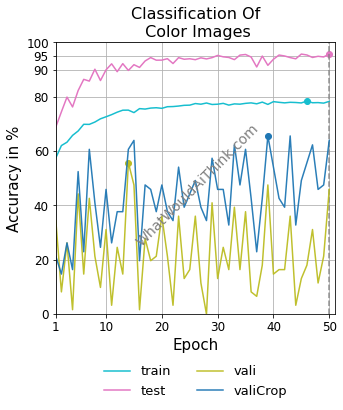

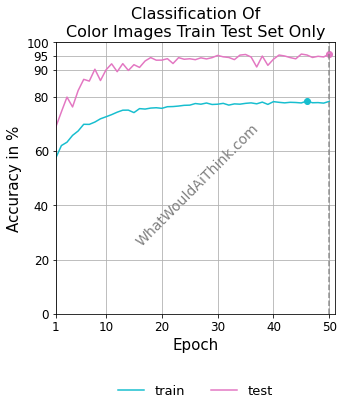

In [21]:
# Train the model
checkpoint="ColorImages"
tm = TrainingManager(lr=0.001, model=model, nameCheckpoint=checkpoint, 
                     batchSize=32, criterion=model.criterion, 
                     datasets={"train": dataSetTrain, 
                      "test": dataSetTest,
                      "vali": dataSetValidate,
                      "valiCrop": dataSetValidateCropped},
                      title="Classification Of\n Color Images")

n_epochs = 0

tm.resume(n_epochs)
# plot only the train and test set
tm.plotLearningProgress(1,50,
                        { key:tm.dicAccuracyList[key] for key in ["train", "test"]},
                        "Classification Of\nColor Images Train Test Set Only")

### Test the trained CNN with the test set


Loading checkpoint: checkpoint_ColorImages_best.pt
Found    4209    true classified images in 4395 images.
Found    186     false classified images in 4395 images.

Confusion Matrix: [[2116   81]
 [ 105 2093]]
Found    2116    images classified as trueDog    in 4395 images.
Found     81     images classified as falseCat   in 4395 images.
Found    105     images classified as falseDog   in 4395 images.
Found    2093    images classified as trueCat    in 4395 images.


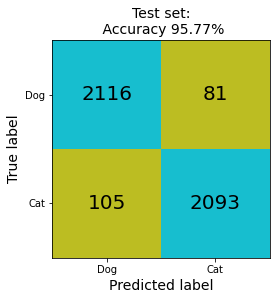

In [22]:
checkPointBest = f"checkpoint_{checkpoint}_best.pt"        
validator = MyValidator(model, checkPointBest, dataSetTest, labelDic, "Test set")
validator.plotConfusionMatrix("Test set", f"ConfusionMatrixTestSetResults{checkpoint}")

### Validate the trained CNN the validation sets


Loading checkpoint: checkpoint_ColorImages_best.pt
Found     28     true classified images in 61 images.
Found     33     false classified images in 61 images.

Confusion Matrix: [[ 0  0]
 [33 28]]
Found     0      images classified as trueDog    in 61 images.
Found     0      images classified as falseCat   in 61 images.
Found     33     images classified as falseDog   in 61 images.
Found     28     images classified as trueCat    in 61 images.


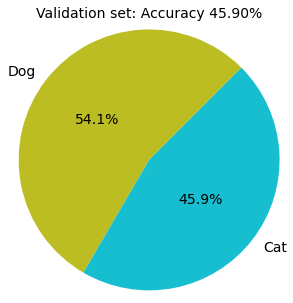

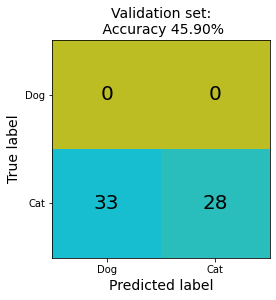

In [23]:
validator = MyValidator(model, checkPointBest, dataSetValidate, labelDic, "Validation set")
validator.plotPie("Validation set", f"PieChartValiSetResults{checkpoint}")
validator.plotConfusionMatrix("Validation set", f"ConfusionMatrixValiSetResults{checkpoint}")


Loading checkpoint: checkpoint_ColorImages_best.pt
Found     39     true classified images in 61 images.
Found     22     false classified images in 61 images.

Confusion Matrix: [[ 0  0]
 [22 39]]
Found     0      images classified as trueDog    in 61 images.
Found     0      images classified as falseCat   in 61 images.
Found     22     images classified as falseDog   in 61 images.
Found     39     images classified as trueCat    in 61 images.


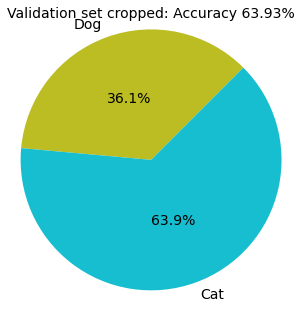

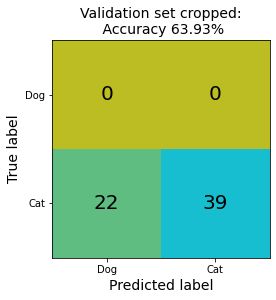

In [24]:
validator = MyValidator(model, checkPointBest, dataSetValidateCropped, labelDic, "Validation set cropped")
validator.plotPie("Validation set cropped", f"PieChartValiSetCroppedResults{checkpoint}")
validator.plotConfusionMatrix("Validation set cropped", f"ConfusionMatrixValiSetCroppedResults{checkpoint}")

### Plot some false and true classified images

Real: Cat -- Classified: Dog
Label: 1 -- Yhat: 0


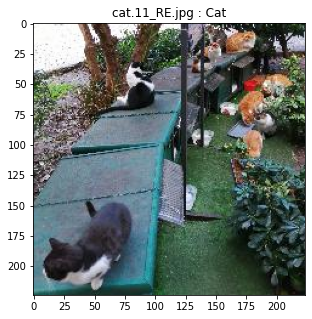

Real: Cat -- Classified: Dog
Label: 1 -- Yhat: 0


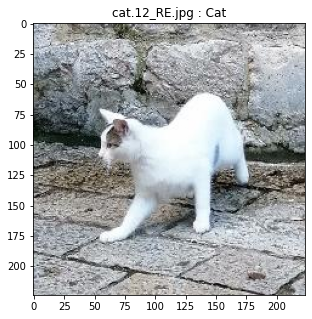

Real: Cat -- Classified: Dog
Label: 1 -- Yhat: 0


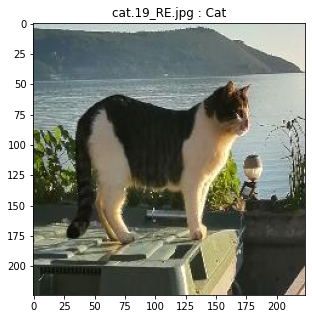

In [25]:
validator.plotClassifiedImages("False", 3)

Real: Cat -- Classified: Cat
Label: 1 -- Yhat: 1


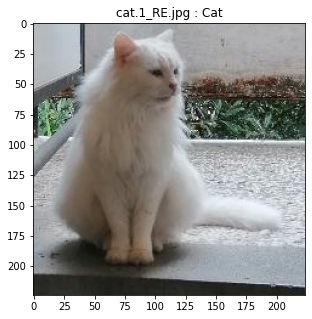

Real: Cat -- Classified: Cat
Label: 1 -- Yhat: 1


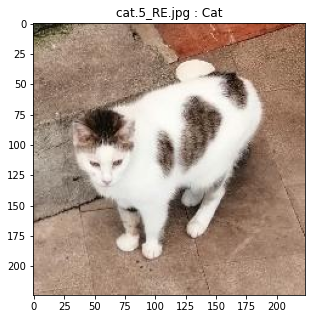

Real: Cat -- Classified: Cat
Label: 1 -- Yhat: 1


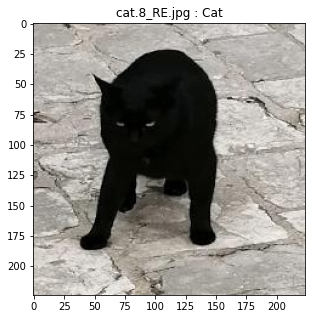

In [26]:
validator.plotClassifiedImages("True", 3)

<h1>4. Augment the training set</h1>

### Apply different transformations on the images in the training set

In [27]:
# create a new directory with subfolders for augmented images with size MIN_SIZE_IMAGE
folders = ["training_set"]           
                     
# augment, resize the images and save it in the new directory             
if createDirectories(pathDataSetAugmented224x224, folders):
    print(f"Augmenting images")
    # transform the resized images
    folder = "training_set"
    transformer = TransformImages(os.path.join(pathDataSet224x224, folder), 
                                  os.path.join(pathDataSetAugmented224x224, folder))

    tic = time.time()

    # move the orignal images
    transformer.noTransform()

    # pad images medium
    transformer.pad("M")

    # invert images
    transformer.invert()

    # convert to grayscale
    transformer.toGrayScale()

    # color jitter images
    transformer.colorJitter("CJ2")

    # create perspective views
    transformer.perspective("P3")
    transformer.perspective("P4")

    # rotate images
    transformer.rotate(45)
    #transformer.rotate(135)
    #transformer.rotate(215)
    transformer.rotate(315)

    print(f"Used time: {time.time() - tic}")

directory: datasets_augmented224x224/training_set/cats already exists
Stop creating any directory


### Overwrite the DataFrame df_train with augmented images

In [28]:
df_train = readDataToDataFrame(os.path.join(pathDataSetAugmented224x224, "training_set"))

Reading files from folder: datasets_augmented224x224/training_set/cats
Reading files from folder: datasets_augmented224x224/training_set/dogs


### Check the new DataFrame and basic statistics.

In [29]:
df_train.describe()

label     width    height
count  158850.000000  158850.0  158850.0
mean        0.499150     224.0     224.0
std         0.500001       0.0       0.0
min         0.000000     224.0     224.0
25%         0.000000     224.0     224.0
50%         0.000000     224.0     224.0
75%         1.000000     224.0     224.0
max         1.000000     224.0     224.0

### Overwrite the DataSet for training with augmented images

In [30]:
dataSetTrain = Data(df_train)

<h1>5. Train a CNN with augmented training images </h1>

In [31]:
# use the same conv layers and create the model
model = CNN(imageSize=MIN_SIZE_IMAGE,
              convLayers=[conv1, conv2, conv3, conv4, conv5], 
              fullConLayers=[1],              
              dropOut=0.5)
display(model)

Creating a CNN with the following architecture:

Convolution Layer: 0
Channels in: 3
Channels out: 32
Reading default parameters for max pooling
Size Image out Conv: (224, 224)
Size Image out MaxPool: (112, 112)

Convolution Layer: 1
Channels in: 32
Channels out: 64
Reading default parameters for max pooling
Size Image out Conv: (112, 112)
Size Image out MaxPool: (56, 56)

Convolution Layer: 2
Channels in: 64
Channels out: 128
Reading default parameters for max pooling
Size Image out Conv: (56, 56)
Size Image out MaxPool: (28, 28)

Convolution Layer: 3
Channels in: 128
Channels out: 256
Reading default parameters for max pooling
Size Image out Conv: (28, 28)
Size Image out MaxPool: (14, 14)

Convolution Layer: 4
Channels in: 256
Channels out: 512
Reading default parameters for max pooling
Size Image out Conv: (14, 14)
Size Image out MaxPool: (7, 7)

Fully connected layer: 0
Number of Neurons: 1

Setting criterion to BinaryCrossEntropyLoss!


CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14)

Number of samples for train: 158850
Number of samples for test: 4395
Number of samples for vali: 61
Number of samples for valiCrop: 61

File checkpoint_ColorImagesAugmented.pt or checkpoint_ColorImagesAugmented_best.pt already exist.
ONLY RESUME TRAINING POSSIBLE!!!.


Loading checkpoint: checkpoint_ColorImagesAugmented.pt
checkpoint[epoch]: 10

Loading checkpoint['accuracy_lists']
valiCrop : [0.5409836065573771, 0.3770491803278688, 0.4262295081967213, 0.26229508196721313, 0.47540983606557374, 0.39344262295081966, 0.4098360655737705, 0.5573770491803278, 0.45901639344262296, 0.4262295081967213]
len = 10
train : [0.6133899905571294, 0.6861756373937677, 0.7211835064526283, 0.7354926030846711, 0.7481397544853635, 0.7574315391879132, 0.7678312873780296, 0.7800818382121498, 0.7720302171860246, 0.7835316336166195]
len = 10
test : [0.7956769055745165, 0.9005688282138794, 0.941296928327645, 0.9435722411831626, 0.944254835039818, 0.940386803185438, 0.9508532423208191, 0.9360637087599545, 0.95017

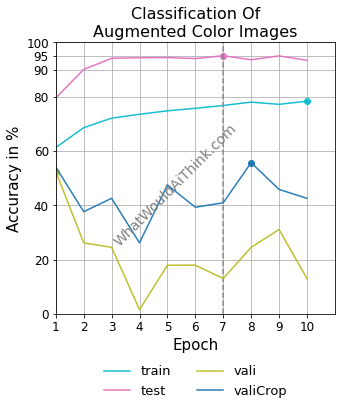

In [32]:
# Train the model
checkpoint="ColorImagesAugmented"
tm = TrainingManager(lr=0.001, model=model, nameCheckpoint=checkpoint, 
                     batchSize=32, criterion=model.criterion,                     
                     datasets={"train": dataSetTrain, 
                      "test": dataSetTest,
                      "vali": dataSetValidate,
                      "valiCrop": dataSetValidateCropped},
                      title="Classification Of\nAugmented Color Images")
n_epochs = 0
tm.resume(n_epochs)

### Test the trained CNN with the test set


Loading checkpoint: checkpoint_ColorImagesAugmented_best.pt
Found    4179    true classified images in 4395 images.
Found    216     false classified images in 4395 images.

Confusion Matrix: [[2029  168]
 [  48 2150]]
Found    2029    images classified as trueDog    in 4395 images.
Found    168     images classified as falseCat   in 4395 images.
Found     48     images classified as falseDog   in 4395 images.
Found    2150    images classified as trueCat    in 4395 images.


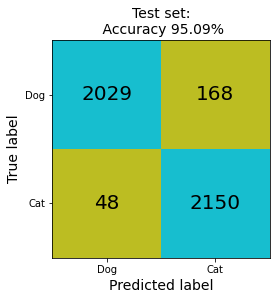

In [33]:
checkPointBest = f"checkpoint_{checkpoint}_best.pt"
validator = MyValidator(model, checkPointBest, dataSetTest, labelDic, "Test set")
validator.plotConfusionMatrix("Test set", f"ConfusionMatrixTestSetResults{checkpoint}")

### Validate the trained CNN with the validation sets


Loading checkpoint: checkpoint_ColorImagesAugmented_best.pt
Found     8      true classified images in 61 images.
Found     53     false classified images in 61 images.

Confusion Matrix: [[ 0  0]
 [53  8]]
Found     0      images classified as trueDog    in 61 images.
Found     0      images classified as falseCat   in 61 images.
Found     53     images classified as falseDog   in 61 images.
Found     8      images classified as trueCat    in 61 images.


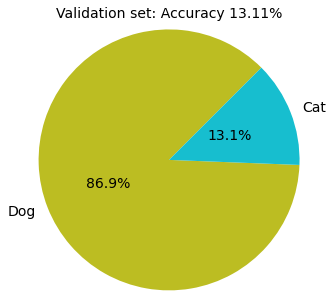

In [34]:
checkPointBest = f"checkpoint_{checkpoint}_best.pt"
validator = MyValidator(model, checkPointBest, dataSetValidate, labelDic, "Validation set")
validator.plotPie("Validation set", f"PieChartValiSetResults{checkpoint}")


Loading checkpoint: checkpoint_ColorImagesAugmented_best.pt
Found     25     true classified images in 61 images.
Found     36     false classified images in 61 images.

Confusion Matrix: [[ 0  0]
 [36 25]]
Found     0      images classified as trueDog    in 61 images.
Found     0      images classified as falseCat   in 61 images.
Found     36     images classified as falseDog   in 61 images.
Found     25     images classified as trueCat    in 61 images.


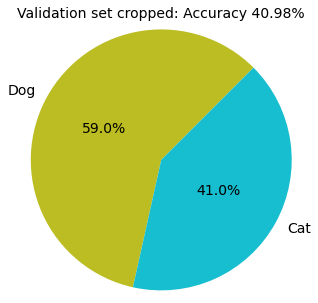

In [35]:
validator = MyValidator(model, checkPointBest, dataSetValidateCropped, labelDic, "Validation set cropped")
validator.plotPie("Validation set cropped", f"PieChartValiSetCroppedResults{checkpoint}")

### Plot some false and true classified images

Real: Cat -- Classified: Dog
Label: 1 -- Yhat: 0


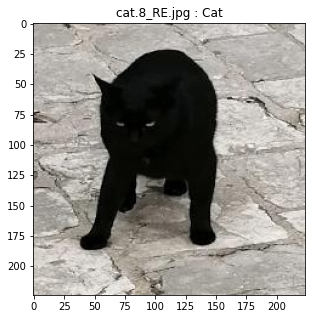

Real: Cat -- Classified: Dog
Label: 1 -- Yhat: 0


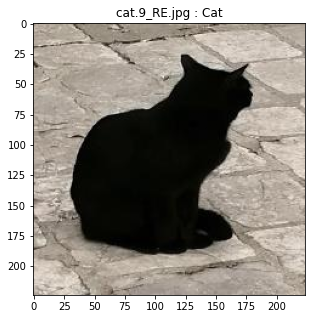

Real: Cat -- Classified: Dog
Label: 1 -- Yhat: 0


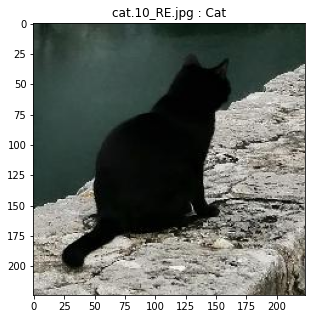

In [36]:
validator.plotClassifiedImages("False", 3)

Real: Cat -- Classified: Cat
Label: 1 -- Yhat: 1


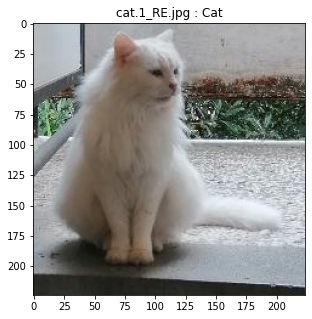

Real: Cat -- Classified: Cat
Label: 1 -- Yhat: 1


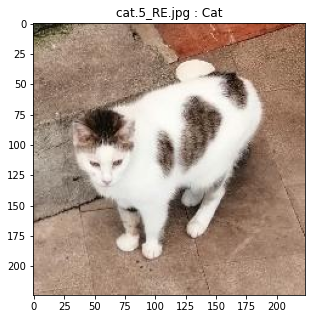

Real: Cat -- Classified: Cat
Label: 1 -- Yhat: 1


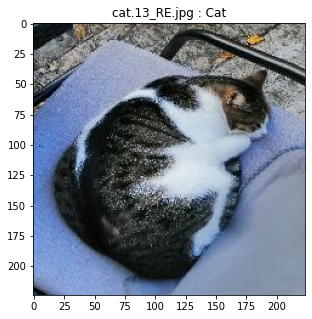

In [37]:
validator.plotClassifiedImages("True", 3)